In [98]:
import pandas as pd
import pandas_profiling
import skfuzzy as fuzz
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

In [86]:
warnings.filterwarnings('ignore')

In [87]:
%matplotlib inline

In [88]:
df = pd.read_csv('data/essalud_data_2017.csv')

In [89]:
report = pandas_profiling.ProfileReport(df)

In [90]:
report.to_file(outputfile='report.html')

In [91]:
counter = 0
columns = []
for column in df.columns:
    if df[pd.isnull(df[column])].shape[0]/df.shape[0] < .8:
        counter += 1
        columns.append(column)
print(counter)

69


In [92]:
df_mean = df[columns]
for column in df_mean.columns:
    if column == 'Unnamed: 0':
        print(True)
    else:
        df_mean.loc[:, column] = df_mean[column].fillna(df_mean[column].mean()).astype(int)

True


In [93]:
df_median = df[columns]
for column in df_median.columns:
    if column == 'Unnamed: 0':
        print(True)
    else:
        df_median.loc[:, column] = df_median[column].fillna(df_median[column].median()).astype(int)

True


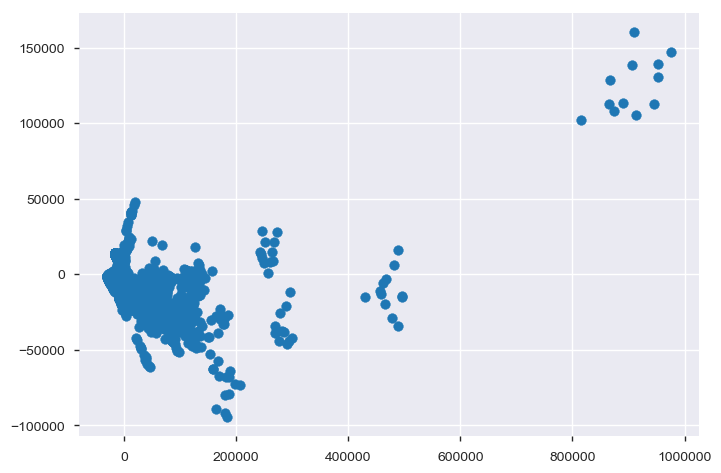

In [94]:
pca = PCA(n_components=0.95)

pc = pd.DataFrame(pca.fit_transform(df_mean[df_mean.keys()[1:]]))

plt.scatter(pc[0], pc[1])

In [136]:
def cluster_hospitals(df, exp_var=0.95, index_col='Unnamed: 0', n_clusters = 11):
    
    periods = ['01','02','03','04','05','06','07','08','09','10','11','12']
    
    c_periods = [[] for i in range(n_clusters + 1)]
    
    for period in tqdm(range(len(periods))):
        
        t = df[df[index_col].str.contains('2017-{}'.format(periods[period]))]
        pca = PCA(n_components=0.95)

        pc = pd.DataFrame(pca.fit_transform(t[t.keys()[1:]]))
        
        cntrs, us, u0s, ds, jms, ps, fpcs, sils = [],[],[],[],[],[],[], []
        
        for i in range(2, n_clusters):
            cntr, u, u0, d, jm, p, fpc = fuzz.cmeans(pc.T, i, 2, error=0.005, maxiter=1500)
            labels = np.argmax(u.T, axis=1)
            cntrs.append(cntr)
            us.append(u)
            u0s.append(u0)
            ds.append(d),
            jms.append(jm)
            ps.append(p)
            fpcs.append(fpc)
            sils.append(silhouette_score(pc, labels))
            
        c_periods[period].append([cntrs, us, u0s, ds, jms, ps, fpcs, sils])
    return c_periods

In [137]:
#cntrs, us, u0s, ds, jms, ps, fpcs, sils = cluster_hospitals(df_mean)

c_periods = cluster_hospitals(df_mean)

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]


In [148]:
c_periods[11][0][-1]

[0.8095245586213207,
 0.7846702346427576,
 0.48217891770597904,
 0.5520074412222056,
 0.5734012383388942,
 0.6702268738439038,
 0.6649823471018342,
 0.6574687516474029,
 0.633498307028004]

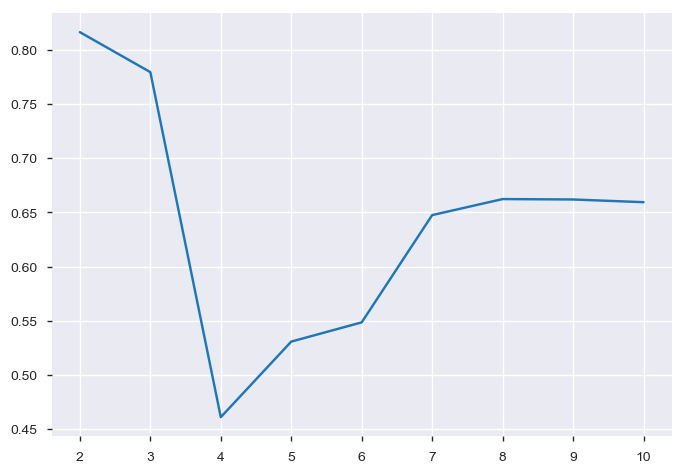

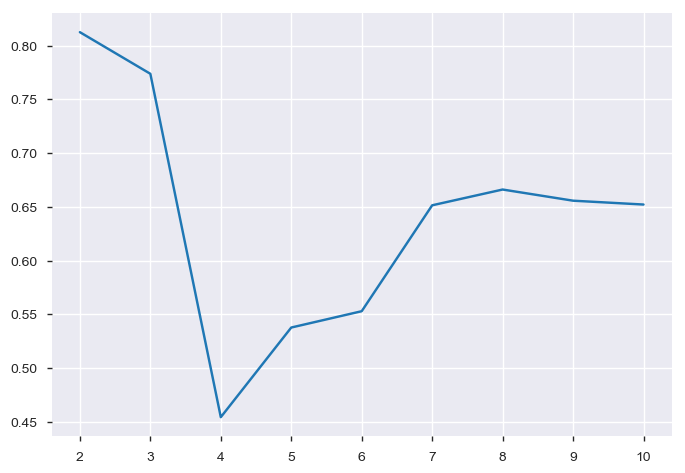

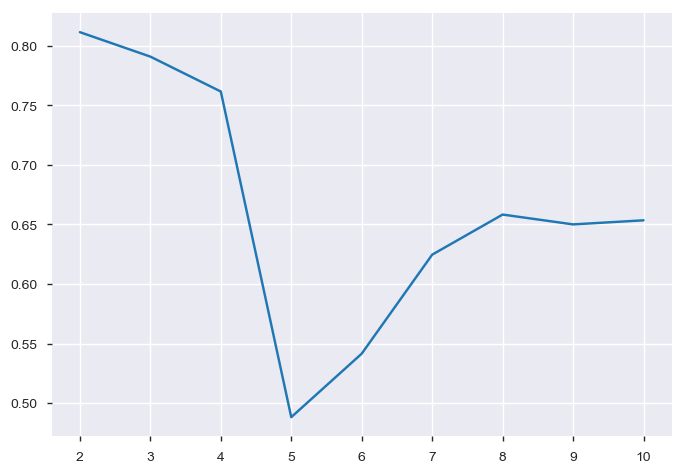

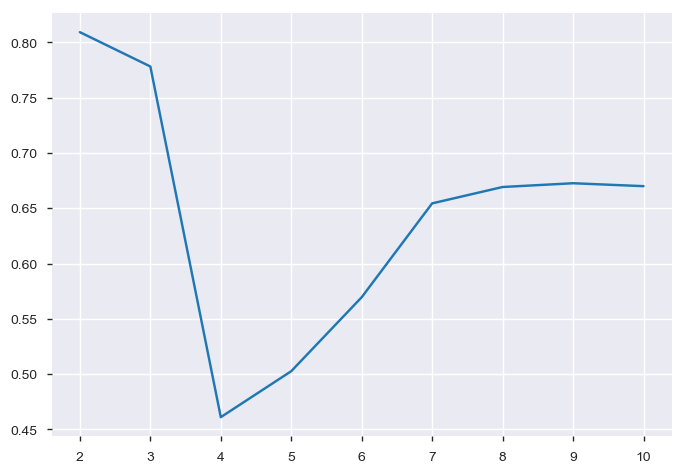

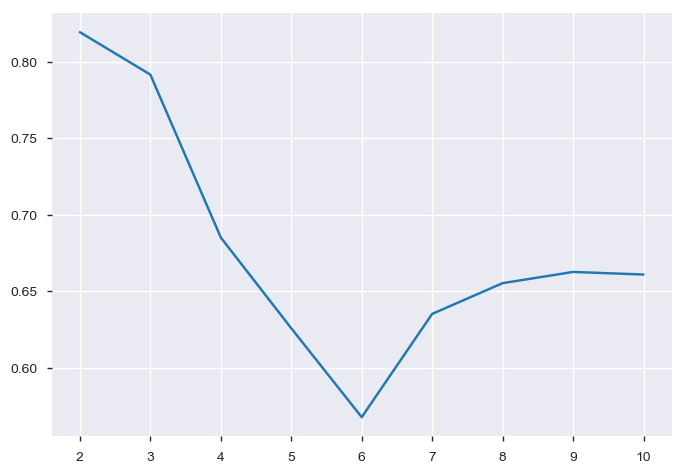

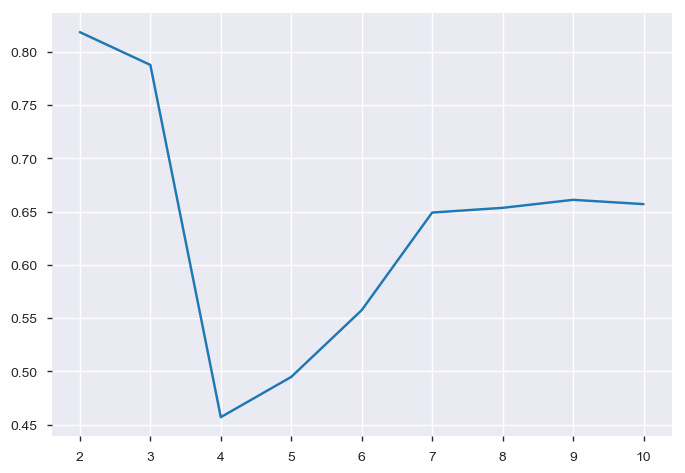

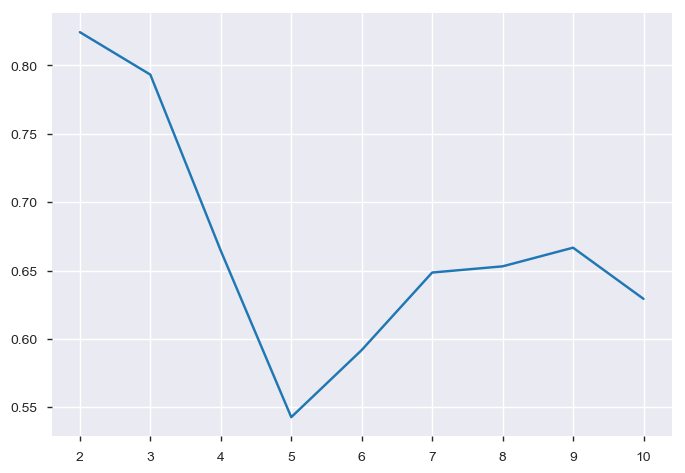

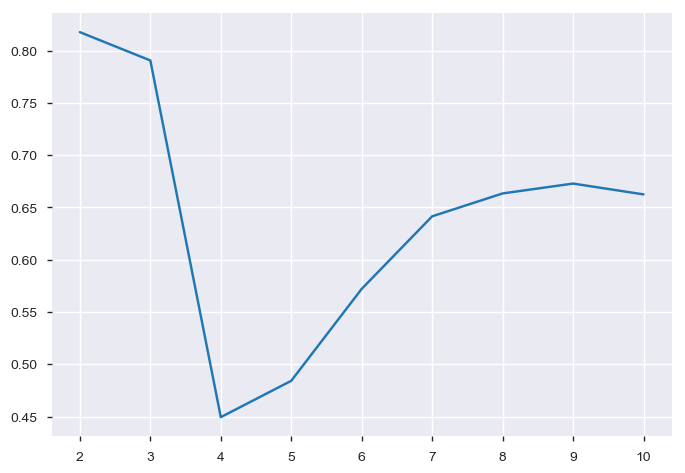

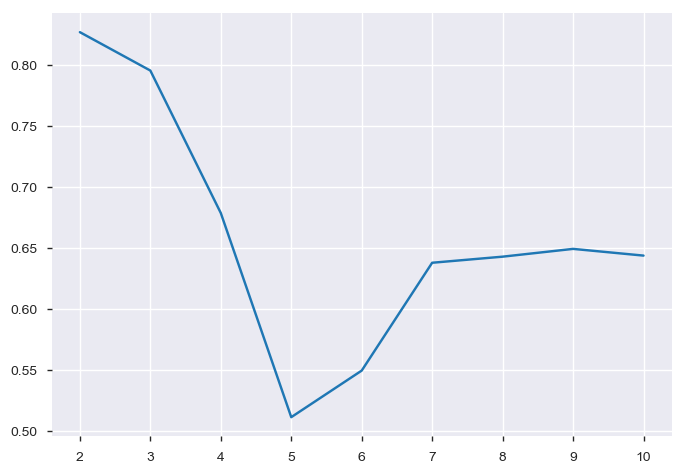

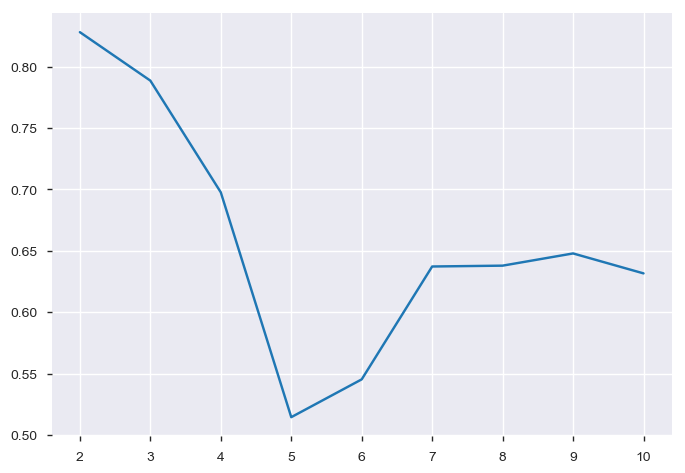

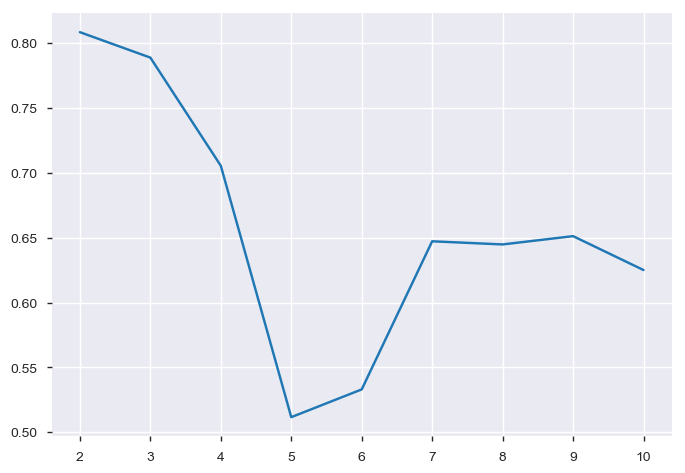

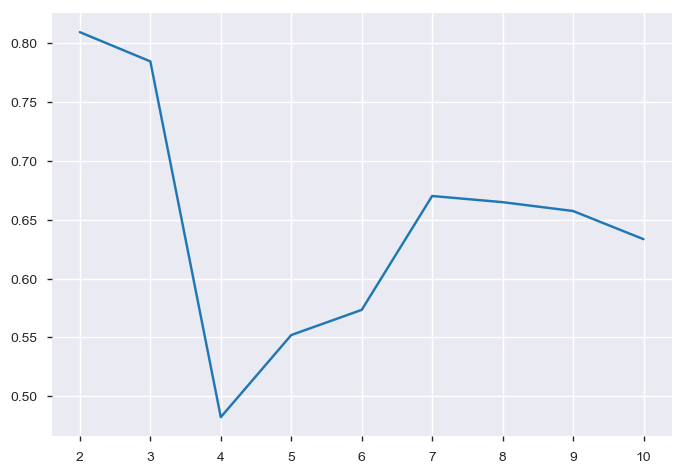

In [150]:
for i in range(12):
    for j in range(len(c_periods[i])):
        plt.plot(range(2,11),c_periods[i][j][-1])
        plt.show()

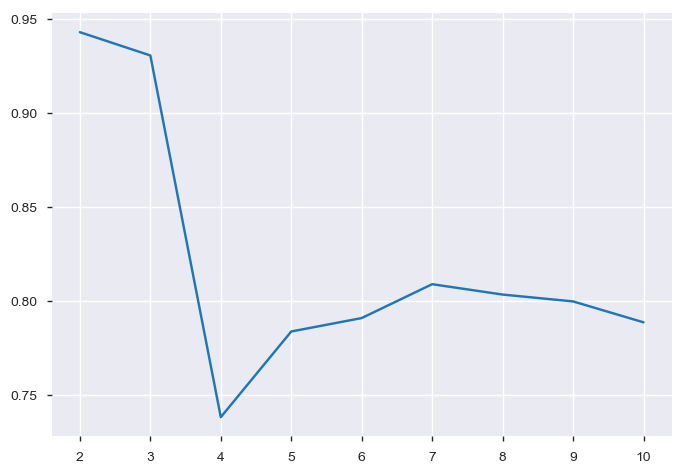

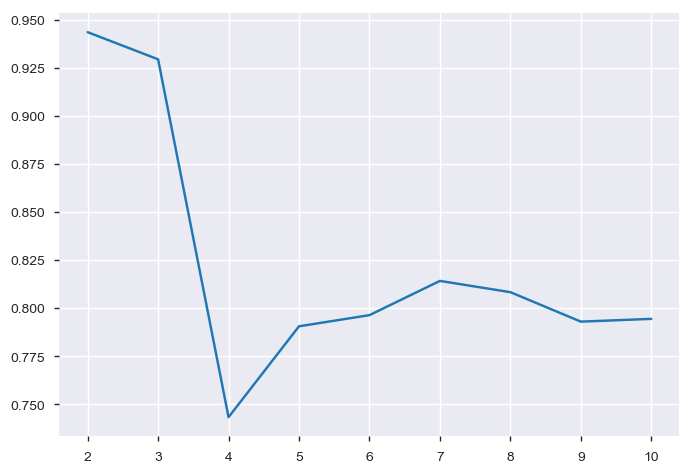

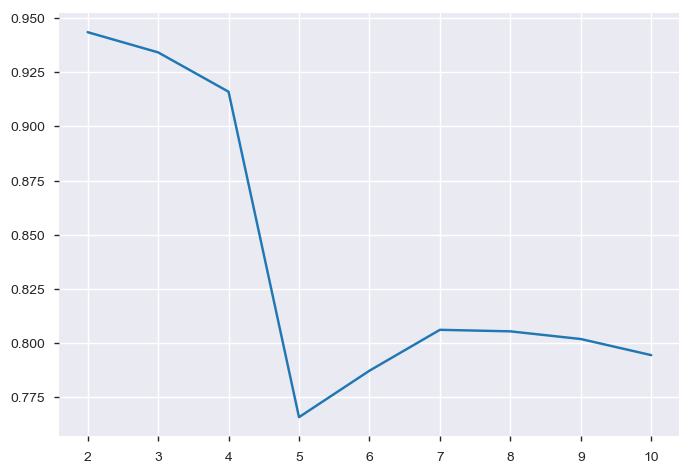

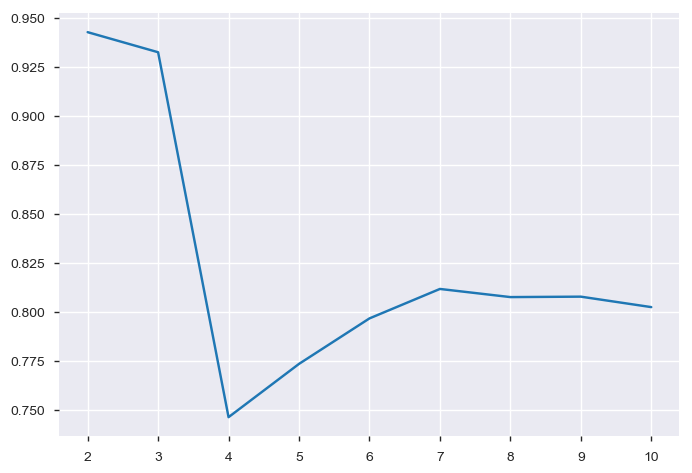

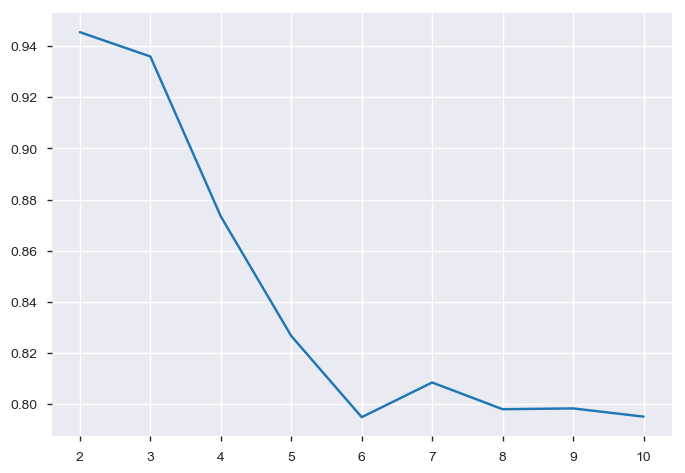

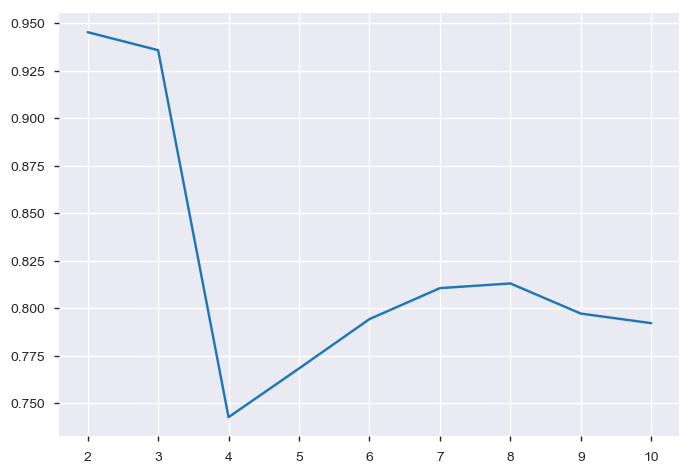

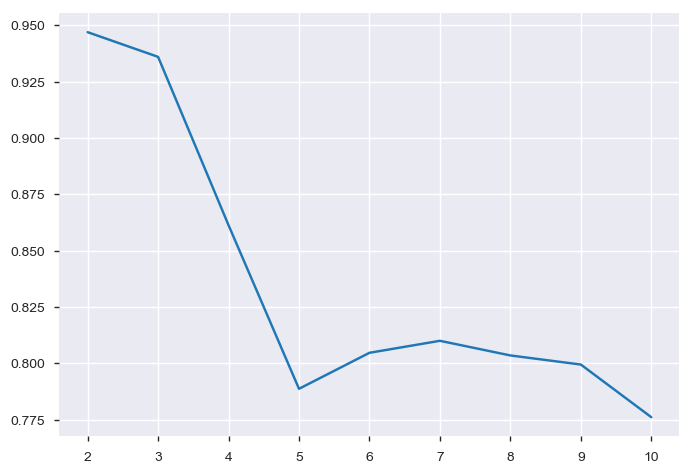

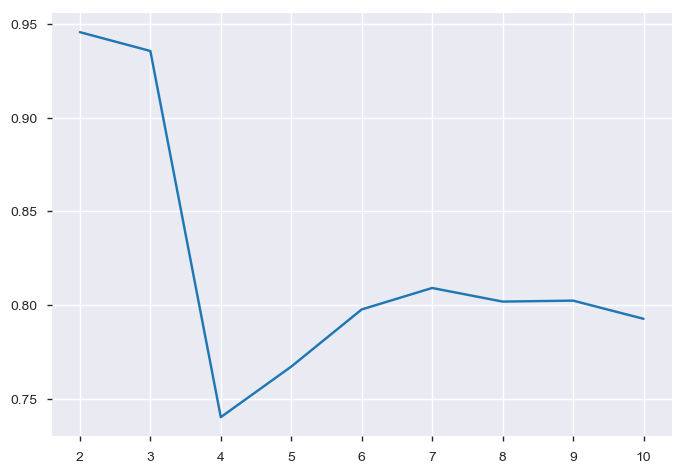

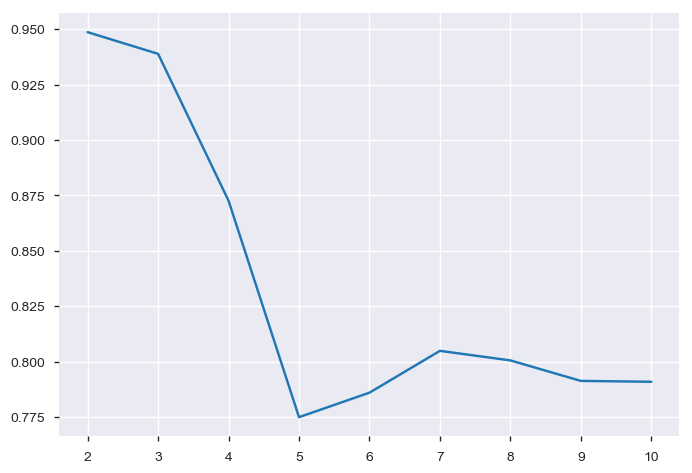

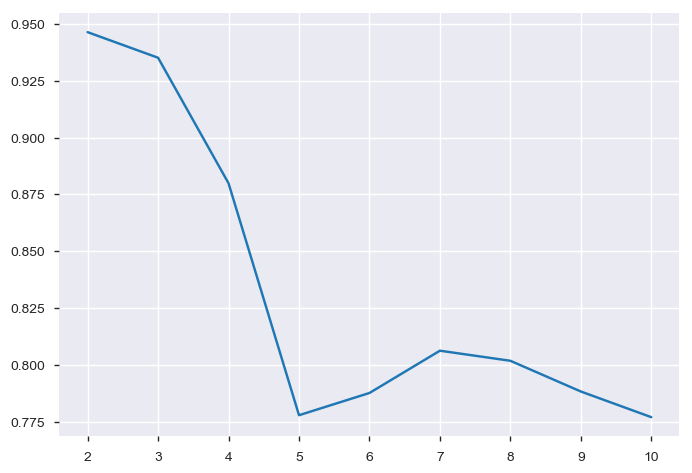

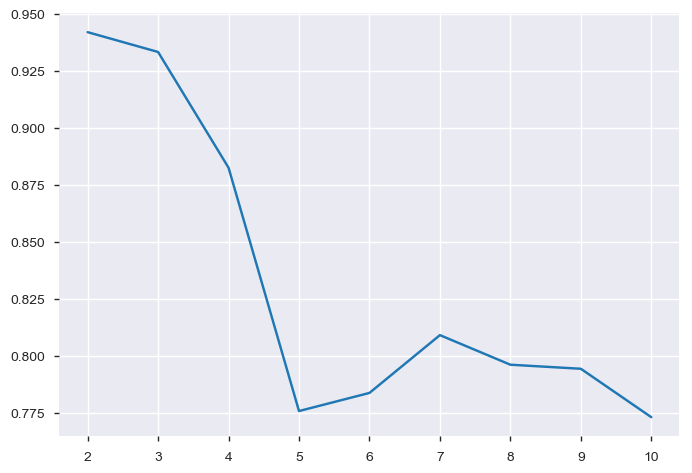

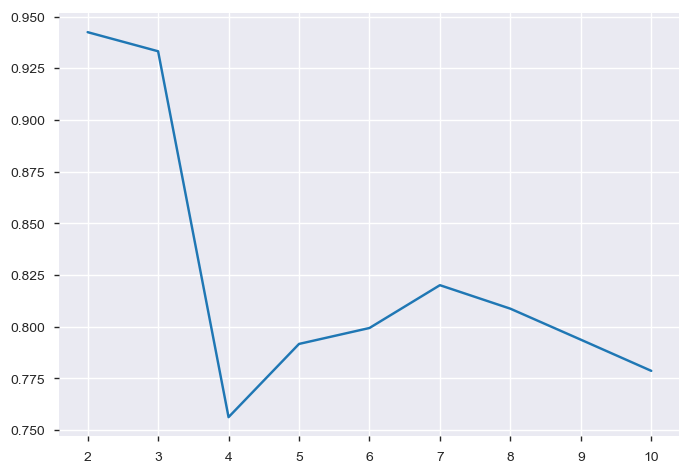

In [151]:
for i in range(12):
    for j in range(len(c_periods[i])):
        plt.plot(range(2,11),c_periods[i][j][-2])
        plt.show()